In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from figure import plot_sig_, plot_sig_2
from eeg_v2 import EEG
from utils import chunks, baseline_calc, butter_bandpass_filter
import joblib
from mne.preprocessing import ICA

# Function and Lib

In [3]:
def _get_ica_map(ica, components=None):
    """Get ICA topomap for components"""
    fast_dot = np.dot
    if components is None:
        components = list(range(ica.n_components_))
    maps = fast_dot(ica.mixing_matrix_[:, components].T,
                    ica.pca_components_[:ica.n_components_])
    return maps

def get_chunks(sig):
    i = 0
    for task in sig.tasks:
        for c in chunks(task, 15):
            i+=1
            yield i, c
            
def count_chunks(sig):
    i = 0
    for task in sig.tasks:
        for c in chunks(task, 15):
            i+=1
    return i

In [4]:
# Reading raw data
path_edf="./edf/1578_alice/edf/A0001578.edf"
path_stage="./edf/1578_alice/csv/STAGE.csv"

eeg = EEG(path_edf=path_edf, path_stage=path_stage)

C:\Users\tudot\Desktop\codes\ica_paper\eeg_v2.py:17: RuntimeWarning: Channel names are not unique, found duplicates for: {'EMG Chin'}. Applying running numbers for duplicates.
  raw = read_raw_edf(self.path_edf, preload=True, verbose=0)


In [5]:
# # Pick a chunks

# _chunks = get_chunks(eeg)
# for i in range(16):
#     _, chunk = next(_chunks)

# print(_)
# print(np.min(chunk),np.max(chunk))

In [6]:
# Preprocessing pipeline
def baseline_bandpass(chunk):
    sample_raw = eeg.raw.copy().crop(np.min(chunk),np.max(chunk),include_tmax=False)
    sample_raw_eog = eeg.eog_channels.copy().crop(np.min(chunk),np.max(chunk),include_tmax=False)


    # Baseline
    sample_raw_baseline = sample_raw.copy()
    sample_raw_baseline = sample_raw_baseline.apply_function(baseline_calc)

    # Bandpass
    sample_raw_bandpass = sample_raw_baseline.copy()
    sample_raw_bandpass = sample_raw_bandpass.apply_function(butter_bandpass_filter)
    
    return sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog

In [7]:
# ICA pipeline
def ica_pipe(sample_raw_bandpass):    
    clf = joblib.load("./models/eog_classifier_v2.joblib")


    sample_raw_train = sample_raw_bandpass.copy()
    sample_raw_corrected = sample_raw_bandpass.copy()

    # Fitting ICA
    ica = ICA(method="extended-infomax", random_state=1)
    ica.fit(sample_raw_corrected)

    maps = _get_ica_map(ica).T
    scalings = np.linalg.norm(maps, axis=0)
    maps /= scalings[None, :]
    X = maps.T

    # Predict EOG
    eog_preds = clf.predict(X)
    list_of_eog = np.where(eog_preds == 1)[0]
    
    # ica.plot_sources(inst=sample_raw_train) 
    # ica.plot_components(inst=sample_raw_train)

    ica.exclude = list_of_eog
    ica.apply(sample_raw_corrected)
    
    return ica, sample_raw_train, sample_raw_corrected

# FIGURE 2

## Raw + After baseline + bandpass

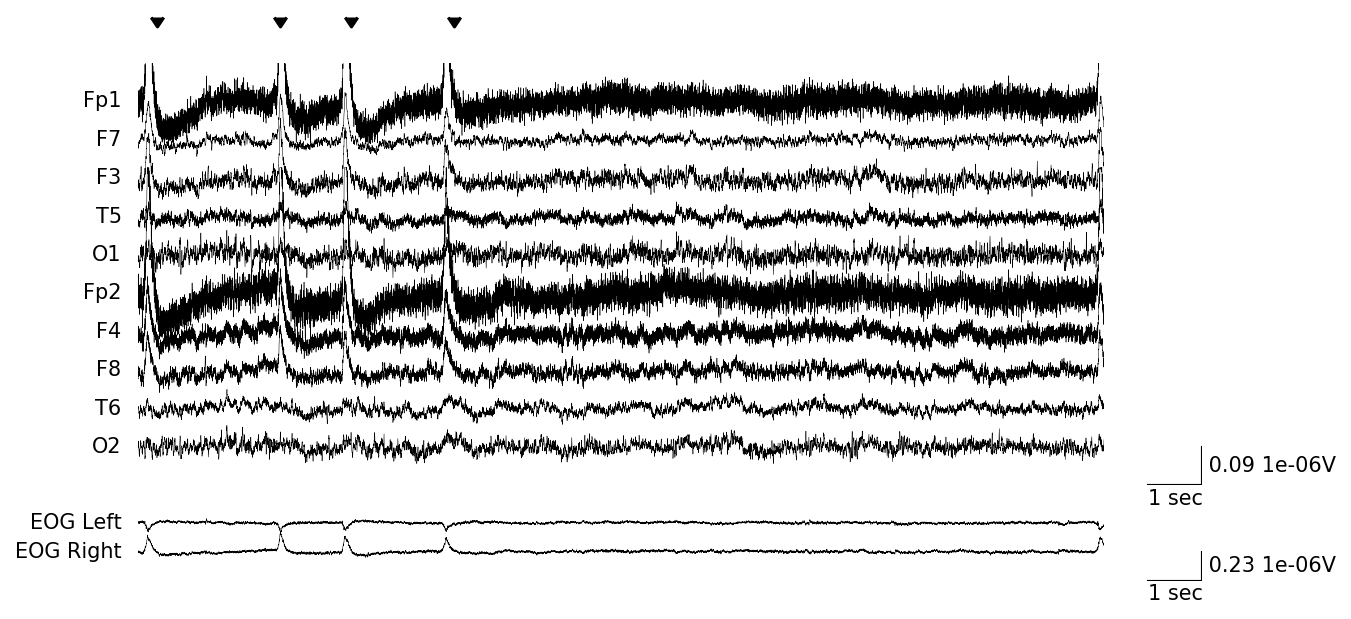

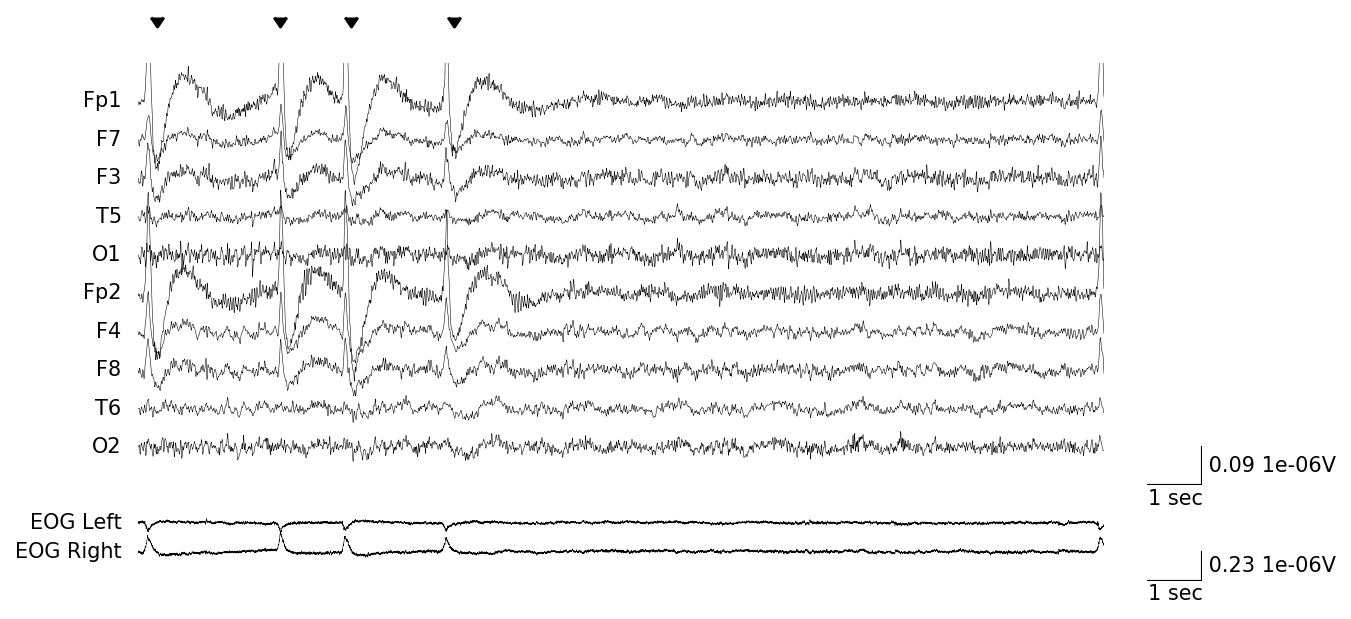

In [19]:
plt.rcParams["figure.figsize"] = [10,5]
PATH = "figures/figure2"
i = 0
for task in eeg.tasks:
    for c in chunks(task, 15):
        i+=1
        
        if i!=7:
            continue
        
        if i>7:
            break
        
        sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog = baseline_bandpass(c)
        # ica, sample_raw_train, sample_raw_corrected = ica_pipe(sample_raw_bandpass)
        

        # Raw
        plot_sig_2(
            sig = sample_raw.get_data() / 1e3,
            fs = 500,
            dpi = 150,
            unit = "1e-06V",
            ch_names = sample_raw.ch_names,
            eog_sig = sample_raw_eog.get_data() / 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
            markers = [.3,2.2,3.3,4.9],
            scale=_scale_after/1e3,
            eog_unit = "1e-06V",
        );
        

        # Baseline + Bandpass
        plot_sig_2(
            sig = sample_raw_bandpass.get_data() / 1e3,
            fs = 500,
            dpi = 150,
            unit = "1e-06V",
            ch_names = sample_raw.ch_names,
            eog_sig = sample_raw_eog.get_data() / 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
            eog_unit = "1e-06V",
            markers = [.3,2.2,3.3,4.9],
            scale=_scale_after/1e3
        );

# FIGURE 3

## Good example

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 10
Computing Extended Infomax ICA


<ipython-input-11-9f71c3044bd4>:10: DeprecationWarning: method='extended-infomax' is deprecated and will be removed in 0.19. If you want to use Extended Infomax, specify method='infomax' together with fit_params=dict(extended=True).
  ica = ICA(method="extended-infomax", random_state=1)


Fitting ICA took 3.0s.
Transforming to ICA space (10 components)
Zeroing out 1 ICA components


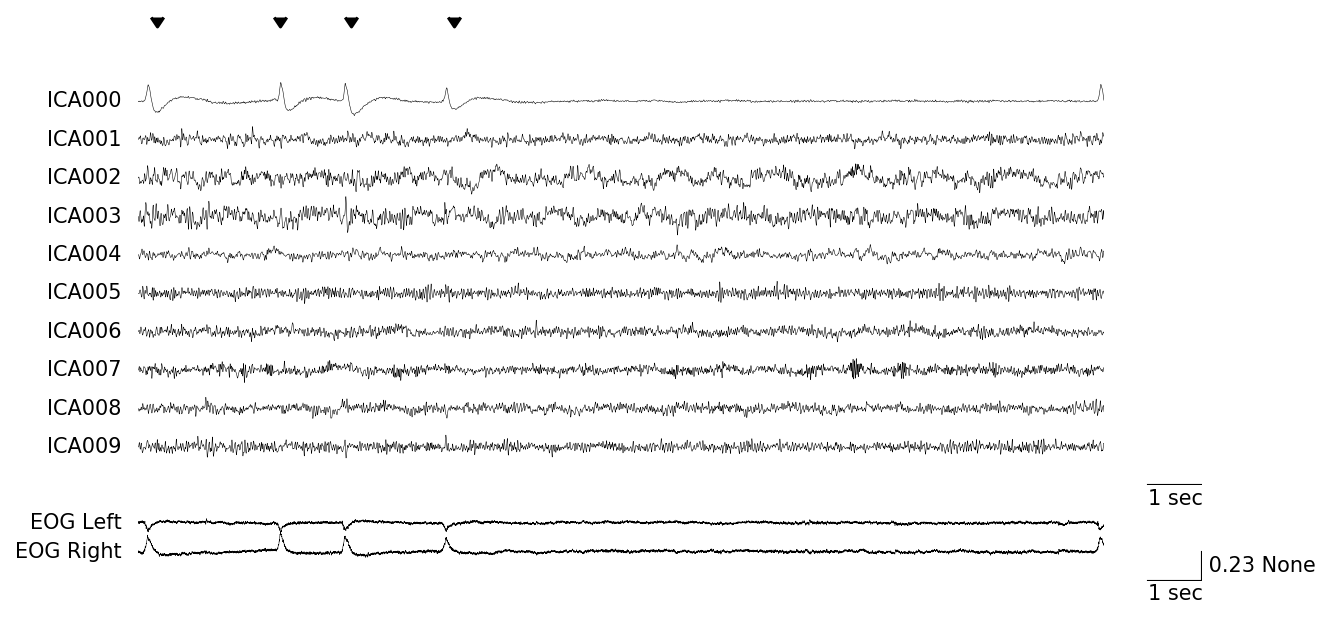

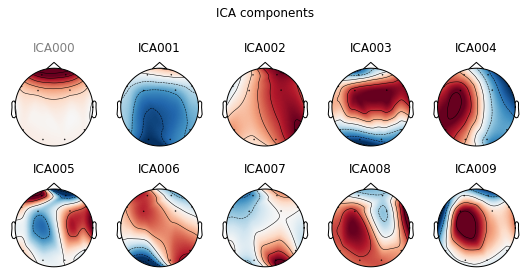

In [13]:
i = 0
PATH = "figures/figure3"
for task in eeg.tasks:
    for c in chunks(task, 15):
        i+=1
        if i!=7:
            continue
        
        if i>7:
            break
        
            
        sample_raw, sample_raw_baseline, sample_raw_bandpass, sample_raw_eog = baseline_bandpass(c)
        ica, sample_raw_train, sample_raw_corrected = ica_pipe(sample_raw_bandpass)
        
        # Save fig
        plot_sig_2(
            sig = ica.get_sources(inst=sample_raw_train).get_data() / 1e3,
            fs = 500,
            dpi = 150,
            # unit = "1e-06V",
            ch_names = ica.get_sources(inst=sample_raw_train).ch_names,
            eog_sig = sample_raw_eog.get_data() / 1e3,
            eog_ch_names = sample_raw_eog.ch_names,
            markers = [.3,2.2,3.3,4.9]
        );
        
        ica.plot_components(inst=sample_raw_train)

# Figure 4

## Before ICA (Bandpass + Baseline)

In [14]:
_scale_after = np.max(sample_raw_corrected.get_data()) - np.min(sample_raw_corrected.get_data())

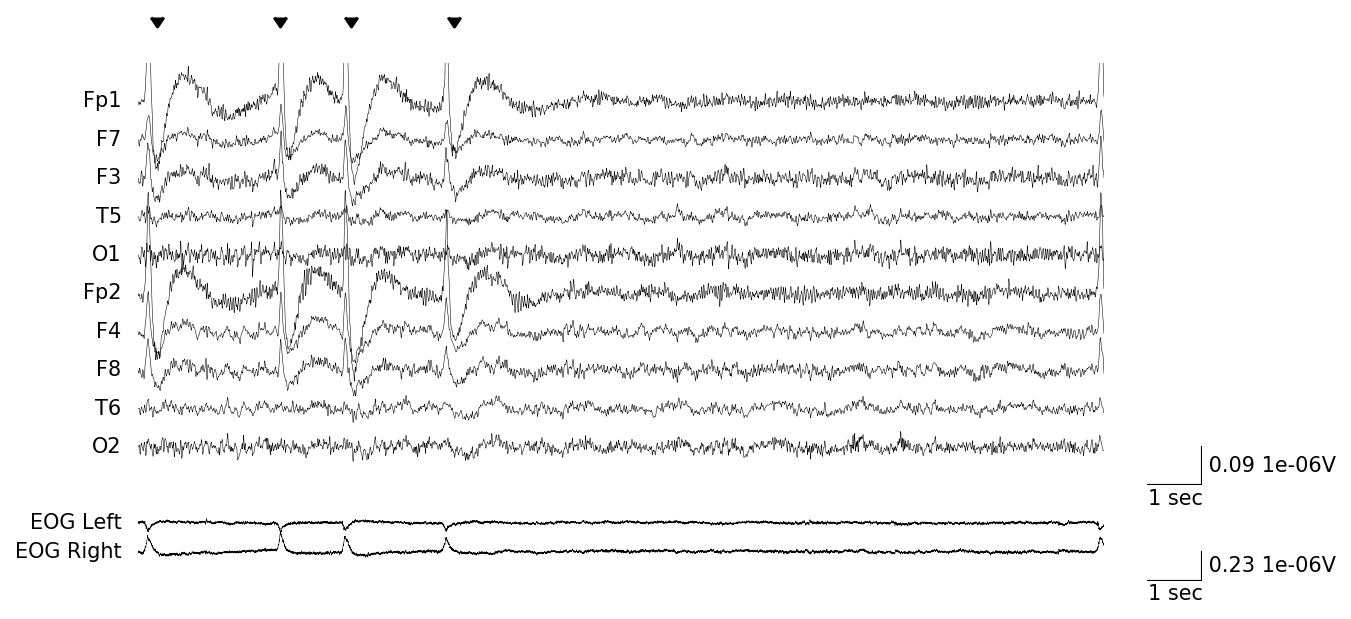

In [18]:
plot_sig_2(
    sig = sample_raw_bandpass.get_data() / 1e3,
    fs = 500,
    dpi = 150,
    unit = "1e-06V",
    ch_names = sample_raw_corrected.ch_names,
    eog_sig = sample_raw_eog.get_data() / 1e3,
    eog_ch_names = sample_raw_eog.ch_names,
    markers = [.3,2.2,3.3,4.9],
    eog_unit="1e-06V",
    scale=_scale_after/1e3
);

## After ICA

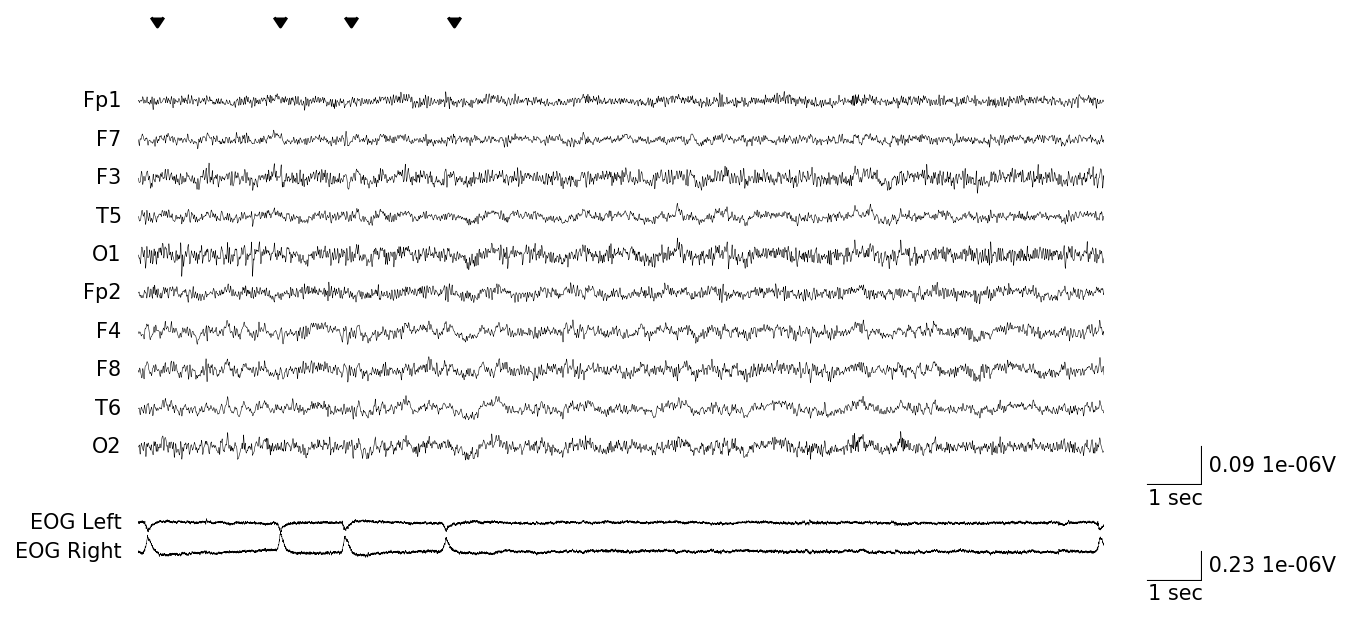

In [17]:
plot_sig_2(
    sig = sample_raw_corrected.get_data() / 1e3,
    fs = 500,
    dpi = 150,
    unit = "1e-06V",
    ch_names = sample_raw_corrected.ch_names,
    eog_sig = sample_raw_eog.get_data() / 1e3,
    eog_ch_names = sample_raw_eog.ch_names,
    eog_unit="1e-06V",
    markers = [.3,2.2,3.3,4.9]
);

In [8]:
def plot_sig_3(sig, **kwargs):
    """
    
    ===
    Example:
        plot_sig_2(
            X,
            fs = 500,
            dpi = 150,
            scale = _scale1,
            unit = "1e-06V",
            ch_names = sample_raw_bandpass.ch_names,
            eog_sig = sample_raw_eog.get_data(),
            eog_ch_names = sample_raw_eog.ch_names,
            markers = [.3,2.2,3.3,4.9]
        );    
    """
    
    # Shape
    n, l = sig.shape
    _min, _max = np.min(sig),np.max(sig)
    
    # Sampling frequency
    fs = kwargs.get("fs")
    assert fs, "Missing fs!!!"
    
    nsec= l/fs
    taxis = np.linspace(0, nsec, l)
    
    # Scale
    if kwargs.get("scale"):
        _scale = kwargs.get("scale")
    else:
        _scale =_max - _min
    
    # DPI
    dpi = kwargs.get("dpi")
    if dpi:
        fig = plt.figure(dpi=dpi)
    else:
        fig = plt.figure()
    
    n_ = n
    
    # EOG signal
    eog_sig = kwargs.get("eog_sig")
    
    try:
        n_eog, _ = eog_sig.shape
    except Exception as e:
        n_eog = 0
        pass
    
    if n_eog:
        eog_ch_names = kwargs.get("eog_ch_names")
        assert eog_ch_names, "Missing EOG ch_names!!!"
        n_ = n + n_eog
    
    gs = GridSpec(n_,12,figure=fig)

    X = np.zeros([n,l])
    
    for i in range(n):
        X[i,:] = sig[i,:] - i * _scale
    
    _min = np.mean(X[-1,:]) - _scale
    _max = np.mean(X[0,:]) + _scale
    
    
    # MARKER
    markers = kwargs.get("markers")
    
    ## Sig
    ax1 = fig.add_subplot(gs[0,1:-1])
    ax1.set(xlim=(0, nsec))
    ax1.axis("off")
    
    if markers:
        for m in markers:
            ax1.scatter(m, 0, marker=11, color="black")
    
    # SIGNAL EEG
    
    
    ## Comp/Chan name
    ch_names = kwargs.get("ch_names")
    assert ch_names, "Missing ch_names!!!"
    
    ax0 = fig.add_subplot(gs[1:-2,0])
    ax0.axis("off")
    for i in range(n):
        ax0.text(
            1, (n-i)/(n+1),
            ch_names[i],
            verticalalignment="center",
            horizontalalignment="right",
        )
    
    
    ## Sig
    ax1 = fig.add_subplot(gs[1:-2,1:-1])
    ax1.set(xlim=(0,nsec),ylim=(_min,_max))
    ax1.axis("off")
    
    for i in range(n):
        ax1.plot(taxis, X[i,:], color="black",linewidth=.25)
    
    ## Scale
    
    ax2 = fig.add_subplot(gs[1:-2,-1])
    ax2.axis("off")
    ax2.set(xlim=(-1,0),ylim=(_min,_max))
    
    ### Temporal scale
    ax2.plot([-10/nsec,0],[_min,_min], color="black")
    ax2.text(
        -5/nsec, _min*1.01,
        "1 sec",
        verticalalignment="top",
        horizontalalignment="center"
    )
    
    unit = kwargs.get("unit")
    if unit:
        ax2.plot([0,0],[_min, _min + _scale], color="black")
        ax2.text(
            0, _min + _scale/2,
            f" {np.round(_scale * 1e6,2)} {unit}",
            verticalalignment="center"
        )
        
    # EOG SIG
    
    ## Comp / ch_name
    ax0 = fig.add_subplot(gs[-2:,0])
    ax0.axis("off")
    for i in range(n_eog):
        ax0.text(
            1, (n_eog-i)/(n_eog+1),
            eog_ch_names[i],
            verticalalignment="center",
            horizontalalignment="right",
        )
    ## Sig
    
    
    X_eog = np.zeros([n_eog,l])
    eog_scale = np.max(eog_sig) - np.min(eog_sig)
    
    for i in range(n_eog):
        X_eog[i,:] = eog_sig[i,:] - i * eog_scale
    
    eog_min = np.mean(X_eog[-1,:]) - eog_scale
    eog_max = np.mean(X_eog[0,:]) + eog_scale
    
    
    ax1 = fig.add_subplot(gs[-2:,1:-1])
    ax1.set(xlim=(0, nsec), ylim=(eog_min, eog_max))
    ax1.axis("off")
    
    for i in range(n_eog):
        ax1.plot(taxis, X_eog[i,:], color="black",linewidth=.25)
    
    
    ## Scale
    ax2 = fig.add_subplot(gs[-2:,-1])
    ax2.axis("off")
    ax2.set(xlim=(-1,0),ylim=(eog_min,eog_max))
    
    ax2.plot([-10/nsec,0],[eog_min,eog_min], color="black")
    
    ax2.text(
        -5/nsec, eog_min*1.05,
        "1 sec",
        verticalalignment="top",
        horizontalalignment="center"
    )
    
    eog_unit = kwargs.get("eog_unit")
    
    ax2.plot([0,0],[eog_min, eog_min + eog_scale], color="black")
    ax2.text(
        0, eog_min + eog_scale/2,
        f" {np.round(eog_scale * 1e6,2)} {eog_unit}",
        verticalalignment="center"
    )
    
    return fig